## Inspection

The following code starts off by inspecting the new dataset. We note two limitations with the current dataset:

1. Each file only contains one tremor event, so it is extremely unbalanced if we just slide a window over the data.

2. The amount of data is extremely small

Extracting EDF parameters from /Users/hikaru/Desktop/parkinsons-tremor-detection/new_data/sub-pd3/ses-off/eeg/sub-pd3_ses-off_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 102399  =      0.000 ...   199.998 secs...
[{'cal': 1.0, 'logno': 1, 'scanno': 1, 'range': 1.0, 'unit_mul': 0 (FIFF_UNITM_NONE), 'ch_name': 'Fp1', 'unit': 107 (FIFF_UNIT_V), 'coord_frame': 4 (FIFFV_COORD_HEAD), 'coil_type': 1 (FIFFV_COIL_EEG), 'kind': 2 (FIFFV_EEG_CH), 'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}, {'cal': 1.0, 'logno': 2, 'scanno': 2, 'range': 1.0, 'unit_mul': 0 (FIFF_UNITM_NONE), 'ch_name': 'AF3', 'unit': 107 (FIFF_UNIT_V), 'coord_frame': 4 (FIFFV_COORD_HEAD), 'coil_type': 1 (FIFFV_COIL_EEG), 'kind': 2 (FIFFV_EEG_CH), 'loc': array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])}, {'cal': 1.0, 'logno': 3, 'scanno': 3, 'range': 1.0, 'unit_mul': 0 (FIFF_UNITM_NONE), 'ch_name': 'F7', 'uni

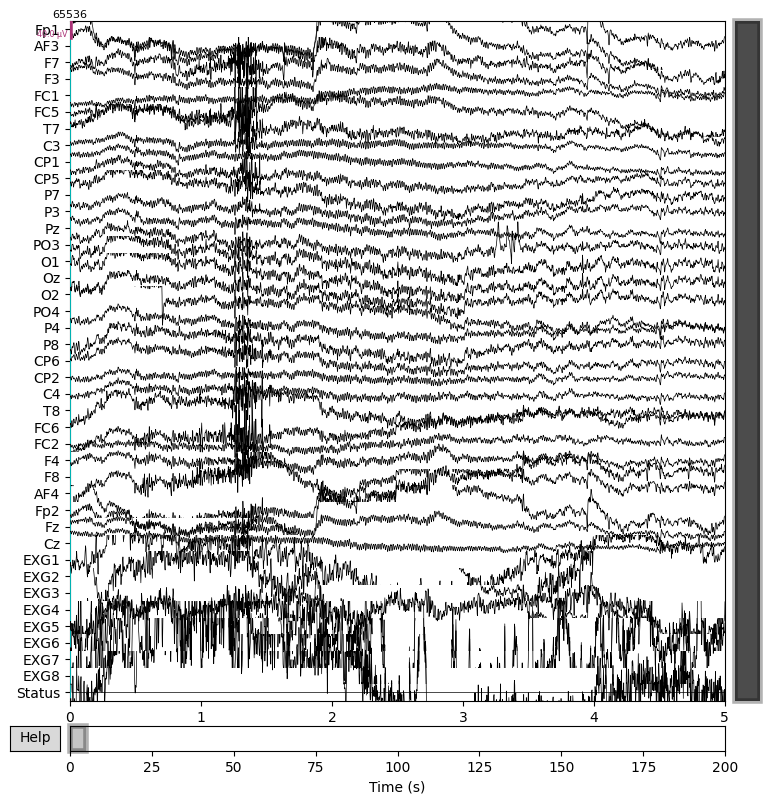

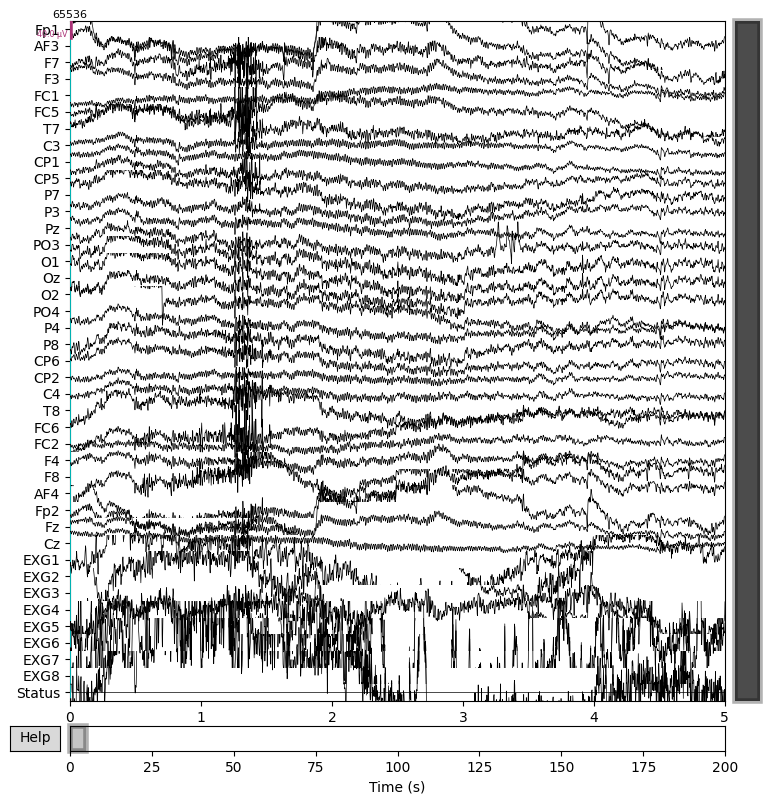

In [2]:
import mne
raw_data = mne.io.read_raw_bdf(f"../new_data/sub-pd3/ses-off/eeg/sub-pd3_ses-off_task-rest_eeg.bdf", preload=True)
print(raw_data.info['chs'])
events, event_id = mne.events_from_annotations(raw_data)

events = mne.find_events(raw_data, stim_channel="Status", initial_event=True)
print(events)

#fig = mne.viz.plot_events(events, sfreq=raw_data.info["sfreq"], first_samp=raw_data.first_samp, event_id=event_id)

raw_data.plot(events=events, n_channels=64, duration=5)



## Plan for Execution

### Preprocessing

1. Load these data, apply some filtering and ICA
2. Find the events and epoch them
3. Slide a window over the data to produce data segments
4. Generate labels 0, 1, 2
    - 0: No tremor
    - 1: Pre-tremor (2 seconds before)
    - 2: Tremor (5 seconds)
5. Crop out the sample after 5 seconds after the tremor ends
6. Apply normalization across channels for each segment
7. Save these data segments and their corresponding label

### Model training

1. Each data sample is one epoch / window with its corresponding label
2. Train a batch of these samples with CNN-LSTM with BCE loss
3. Apply k-fold cross-validation since the data is limited

### Inference

1. Take the continuous EEG data and slide a window over it to produce these epochs / windows
2. The model will be able to take in a window and output a prediction (0/1)
3. Keep sliding the window (increments of 1 second or more)

> The following contains code for the first step of preprocessing.

In [3]:
import torch
import numpy as np
import mne
from sklearn.preprocessing import StandardScaler
import sys

sys.path.append('../')
from preprocessors.eeg_preprocessor_helper import EEGProcessHelper 

In [ ]:
from mne.time_frequency import psd_array_welch

def load_and_preprocess_bdf(file_paths, 
                            event_id,
                            window_size=3.0, 
                            window_step=0.5, 
                            pre_tremor_window=2.0, 
                            save_path=None):
    """
    Load and preprocess BDF files with sliding windows and multi-class labeling.
    
    Args:
        file_paths: List of BDF file paths
        window_size: Window size in seconds (3-4s recommended for 5s tremor events)
        window_step: Step size for sliding window in seconds (smaller = more overlap)
        pre_tremor_window: Time before tremor onset to label as pre-tremor (seconds)
        save_path: Optional path to save processed data
    
    Returns:
        Tuple of (windows, labels) as PyTorch tensors
    """
    all_windows = []
    all_labels = []

    for file_path in file_paths:
        # 1. Load data and apply basic preprocessing
        raw = mne.io.read_raw_bdf(file_path, preload=True)
        #raw.filter(0.5, 50, fir_design='firwin')
        raw.filter(l_freq=0.5, h_freq=50, fir_design="firwin")

        
        # ica = mne.preprocessing.ICA(n_components=15, random_state=42)
        # ica.fit(raw)
        # eog_indices, eog_scores = ica.find_bads_eog(raw)
        # if eog_indices:
        #     ica.exclude = eog_indices
        # ica.apply(raw)
        
        # 2. Get sampling frequency and calculate window parameters
        sfreq = raw.info['sfreq']
        samples_per_window = int(window_size * sfreq)
        step_samples = int(window_step * sfreq)
        pre_tremor_samples = int(pre_tremor_window * sfreq)
        # NOTE: Somehow it cannot find built-in event_id
        events = mne.find_events(raw, stim_channel='Status')
        
        if 'tremor' not in event_id:
            print(f"Warning: 'tremor' event not found in {file_path}. Available events: {event_id}")
            continue
        
        tremor_events = [evt for evt in events if evt[2] == event_id['tremor']]
        if not tremor_events:
            print(f"Warning: No tremor events found in {file_path}")
            continue
        
        # NOTE: We are guaranteed each sample only contain ONE tremor event
        onset = tremor_events[0][0]

        # NOTE: Assuming each tremor lasts about 5 seconds 
        tremor_duration_samples = int(5.0 * sfreq)
        tremor_end = onset + tremor_duration_samples
        # NOTE: Trim seach recording 5 seconds after tremor (so that duration of tremor after 5 seconds does not matter)
        buffer_samples = int(5 * sfreq)
        analysis_end_sample = tremor_end + buffer_samples
        
        # 3. Get raw data and create sliding windows
        data = raw.get_data()
        n_samples = data.shape[1]
        analysis_end_sample = min(analysis_end_sample, n_samples)

        #use only upto channel 32 (Cz) as rest of it is EMG data 
        last_channel = 32 
        
        
        for start_sample in range(0, analysis_end_sample - samples_per_window, step_samples):
            end_sample = start_sample + samples_per_window
            
            # Extract window
            window = data[0:last_channel, start_sample:end_sample]
            
            # 4. Determine the label for this window based on its relation to tremor events
            label = 0 # No tremor

            # Check if window ends right before tremor onset (pre-tremor)
            if onset - pre_tremor_samples <= end_sample <= onset:
                label = 1  # Pre-tremor
                
            # Check if window overlaps with tremor event
            elif start_sample <= onset + tremor_duration_samples and end_sample >= onset:
                label = 2  # Full tremor
            
            # 5. Normalize the window - comment out for non-deep learning methods 
            scaler = StandardScaler()
            window = scaler.fit_transform(window.T).T

            all_windows.append(window)
            all_labels.append(label)

    if not all_windows:
        raise ValueError("No valid data was processed. Check input files and event markers.")
    
    all_windows_preconversion = all_windows
    all_labels_preconversion = all_labels

    all_windows = torch.tensor(all_windows, dtype=torch.float32)
    all_labels = torch.tensor(all_labels, dtype=torch.long)
    
    class_counts = np.bincount(all_labels.numpy())
    print(f"Class distribution:")
    print(f"  Class 0 (No tremor): {class_counts[0] if len(class_counts) > 0 else 0}")
    print(f"  Class 1 (Pre-tremor): {class_counts[1] if len(class_counts) > 1 else 0}")
    print(f"  Class 2 (Full tremor): {class_counts[2] if len(class_counts) > 2 else 0}")
    
    if save_path:
        torch.save({'windows': all_windows, 'labels': all_labels}, save_path)
        
    print(f"Processed {len(all_windows)} windows with shape {all_windows.shape}")
    
    #convert to numpy array 
    all_windows_preconversion = np.array(all_windows_preconversion)
    return all_windows, all_labels, all_windows_preconversion, all_labels_preconversion

In [5]:
import os
import glob

window_size = 3.0
window_step = 0.5
pre_tremor_window = 2.0
event_id = {
    "no-tremor": 65536,
    "tremor": 1
}

dirname = "../new_data"
pattern = os.path.join(dirname, "sub-pd*/ses-off/eeg/sub-pd*_ses-off_task-rest_eeg.bdf")
file_paths = glob.glob(pattern)
print(file_paths)

['../new_data/sub-pd3/ses-off/eeg/sub-pd3_ses-off_task-rest_eeg.bdf', '../new_data/sub-pd5/ses-off/eeg/sub-pd5_ses-off_task-rest_eeg.bdf', '../new_data/sub-pd23/ses-off/eeg/sub-pd23_ses-off_task-rest_eeg.bdf', '../new_data/sub-pd12/ses-off/eeg/sub-pd12_ses-off_task-rest_eeg.bdf', '../new_data/sub-pd13/ses-off/eeg/sub-pd13_ses-off_task-rest_eeg.bdf', '../new_data/sub-pd14/ses-off/eeg/sub-pd14_ses-off_task-rest_eeg.bdf', '../new_data/sub-pd22/ses-off/eeg/sub-pd22_ses-off_task-rest_eeg.bdf', '../new_data/sub-pd9/ses-off/eeg/sub-pd9_ses-off_task-rest_eeg.bdf', '../new_data/sub-pd6/ses-off/eeg/sub-pd6_ses-off_task-rest_eeg.bdf', '../new_data/sub-pd11/ses-off/eeg/sub-pd11_ses-off_task-rest_eeg.bdf', '../new_data/sub-pd16/ses-off/eeg/sub-pd16_ses-off_task-rest_eeg.bdf', '../new_data/sub-pd28/ses-off/eeg/sub-pd28_ses-off_task-rest_eeg.bdf', '../new_data/sub-pd17/ses-off/eeg/sub-pd17_ses-off_task-rest_eeg.bdf', '../new_data/sub-pd19/ses-off/eeg/sub-pd19_ses-off_task-rest_eeg.bdf', '../new_data/

In [6]:
save_path = 'processed_data.pt'
mne.set_log_level('WARNING')
preprocessed_data, labels, all_windows_preconversion, all_labels_preconversion = load_and_preprocess_bdf(file_paths, 
                                                   event_id=event_id,
                                                   window_size=window_size, 
                                                   window_step=window_step,
                                                   pre_tremor_window=pre_tremor_window,
                                                   save_path=save_path)
print(f"Data shape: {preprocessed_data.shape}, Labels shape: {labels.shape}")

Class distribution:
  Class 0 (No tremor): 116
  Class 1 (Pre-tremor): 37
  Class 2 (Full tremor): 238
Processed 391 windows with shape torch.Size([391, 32, 1536])
Data shape: torch.Size([391, 32, 1536]), Labels shape: torch.Size([391])


/var/folders/rq/648fb68j5gs2xvsvbb068_5h0000gn/T/ipykernel_32148/694057582.py:105: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  all_windows = torch.tensor(all_windows, dtype=torch.float32)


In [7]:
#extract features 
EEG_processor = EEGProcessHelper(all_windows_preconversion)

EEG_processor.extract_features(scale = False, save = False)


(391, 32)
Feature shape: (391, 32, 17)
Extraction complete


In [8]:
#saves the extracted featues 
file_name = 'EEG_features.npy'
np.save(file_name, EEG_processor.features)

#saves the labels 
file_name = 'labels.npy'
np.save(file_name, all_labels_preconversion)


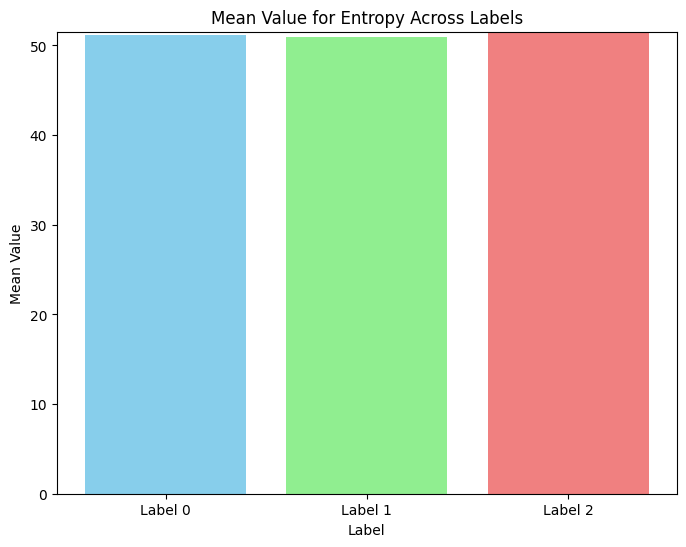

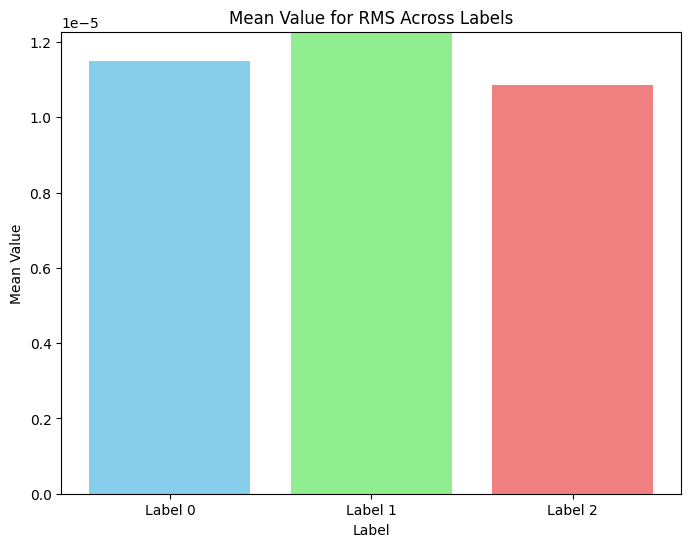

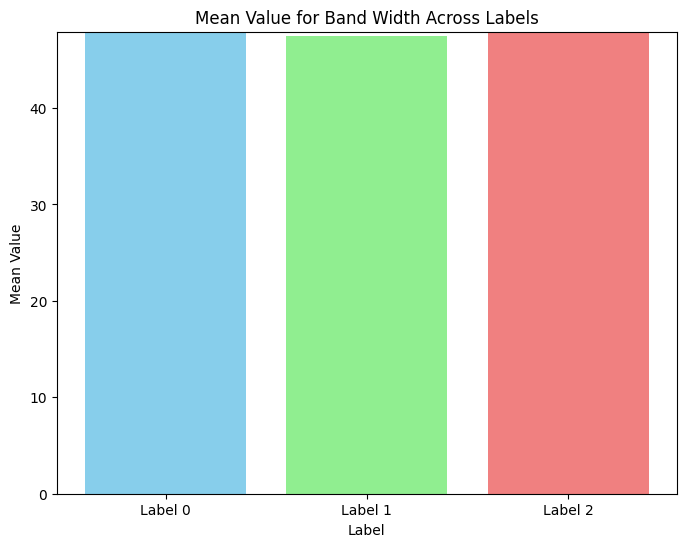

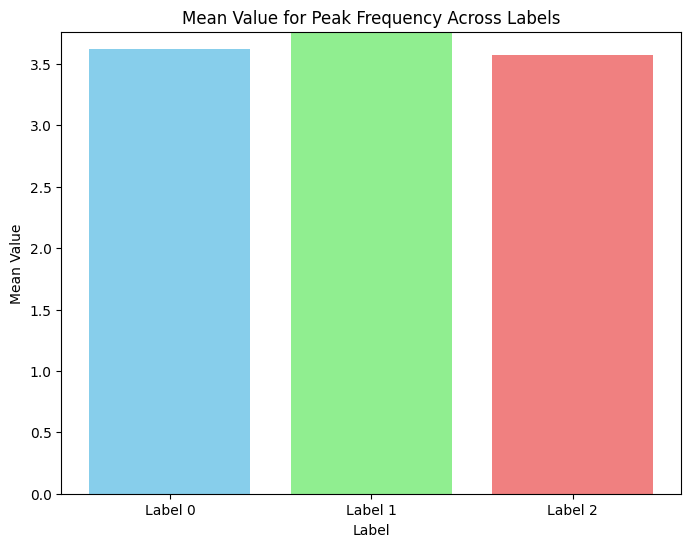

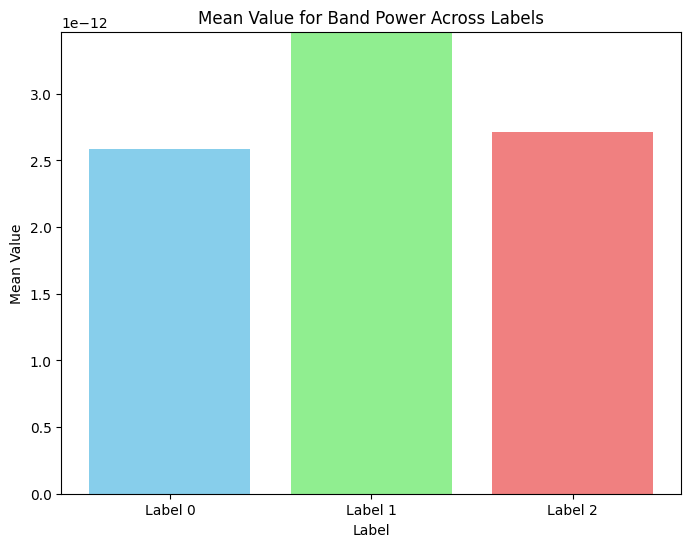

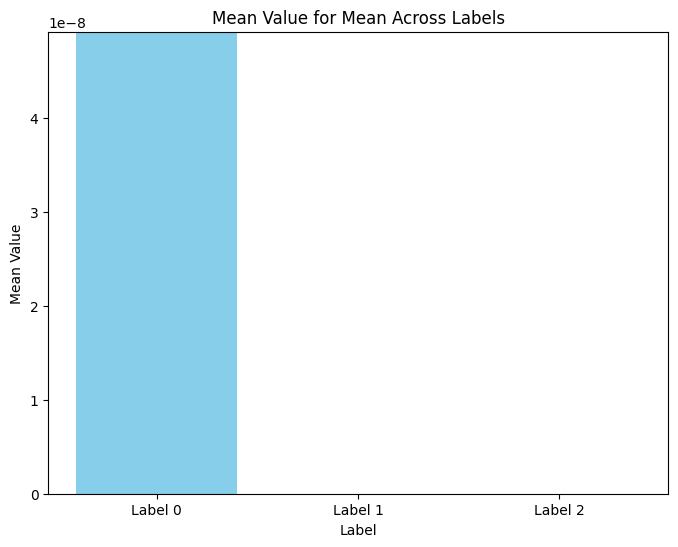

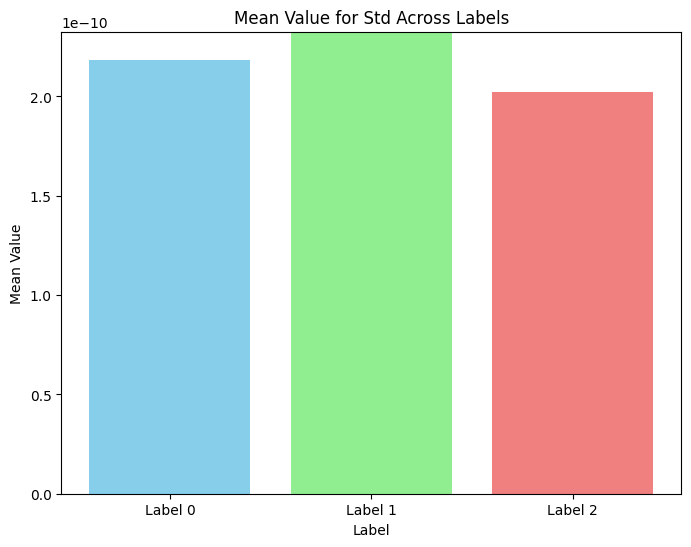

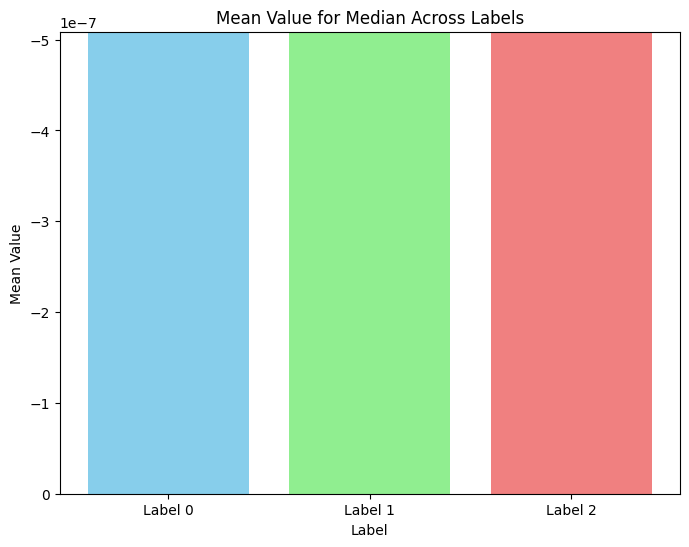

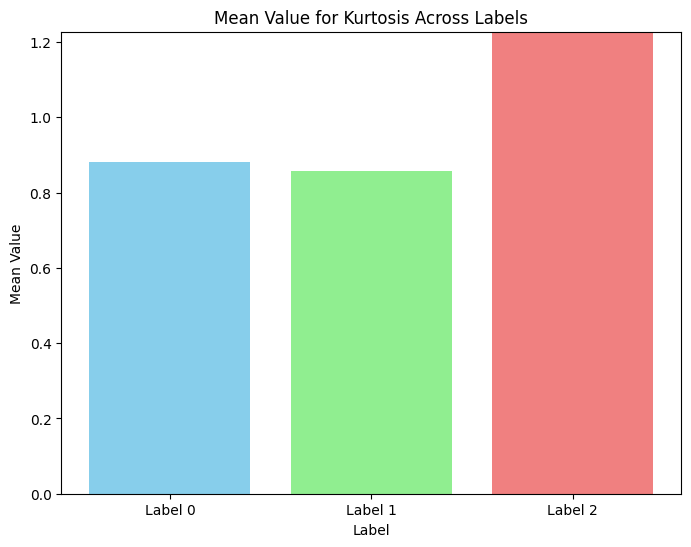

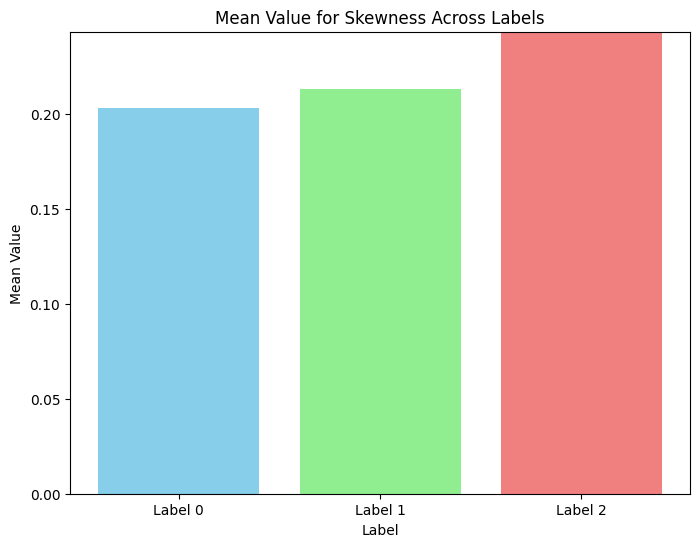

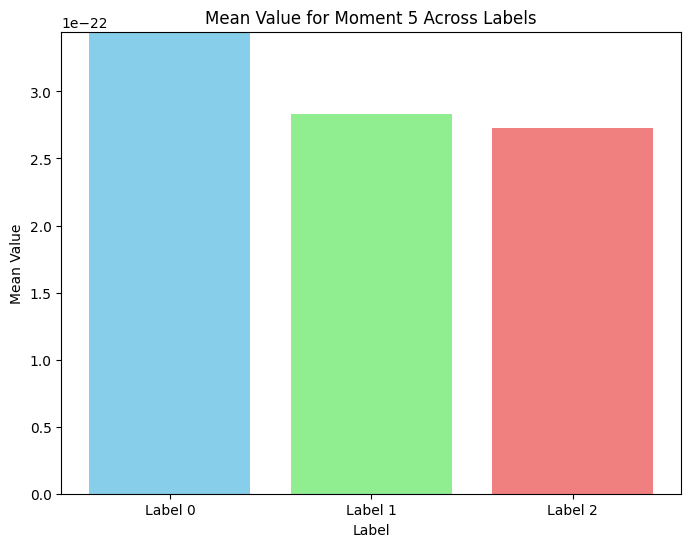

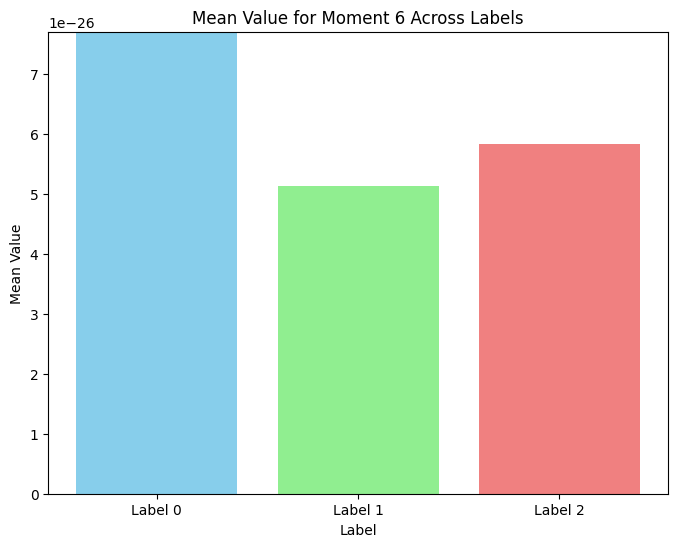

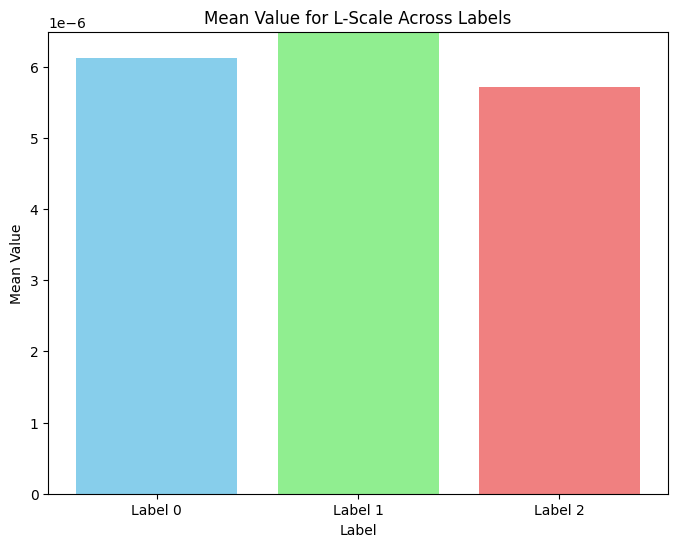

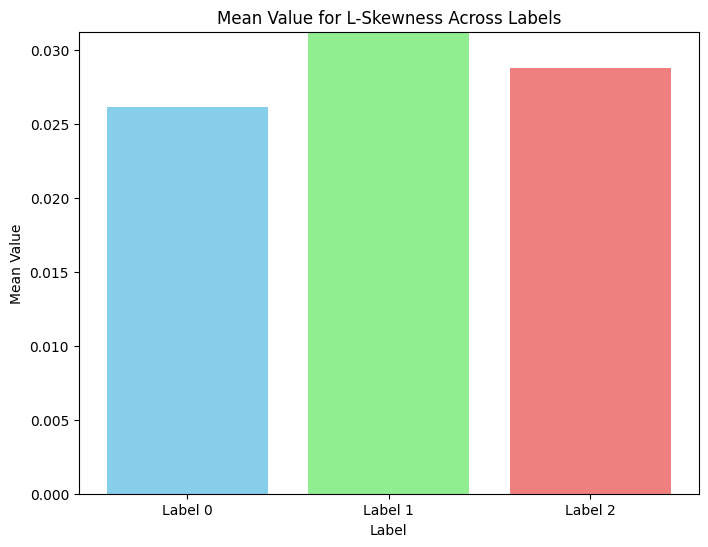

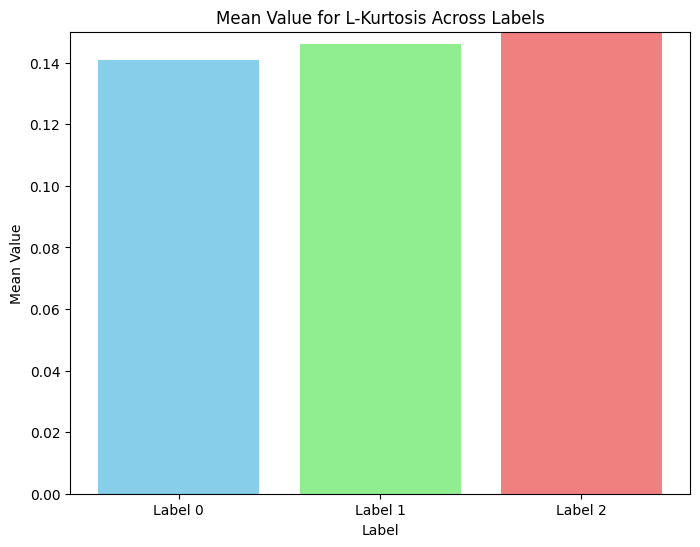

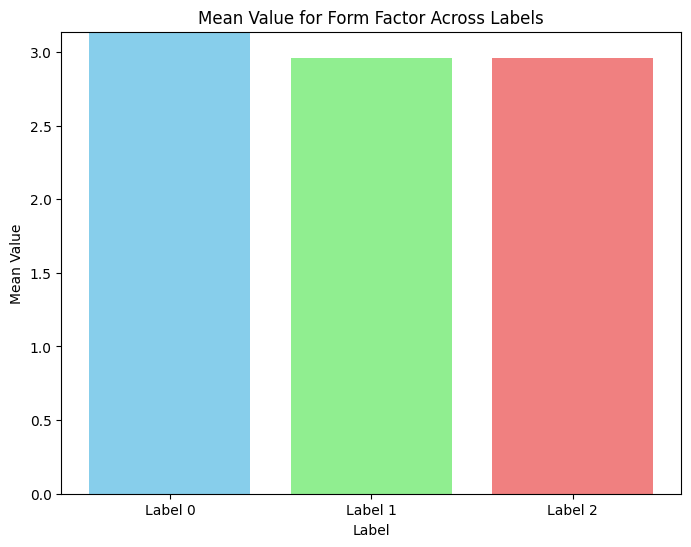

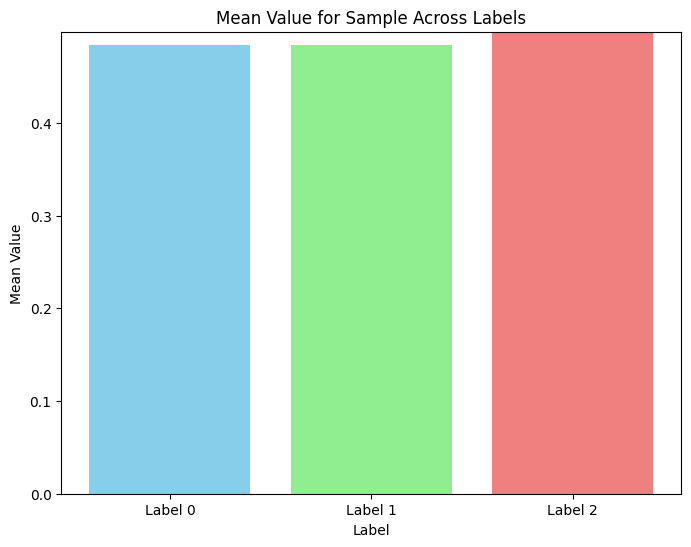

KeyError: slice(None, None, None)

In [ ]:
#plot each features based on label groups 
import numpy as np
import matplotlib.pyplot as plt

features = EEG_processor.features
# Compute the mean across epochs for each label group
means_by_label = {label: [] for label in np.unique(all_labels_preconversion)}

feature_names = [
    'Entropy', 'RMS', 'Band Width', 'Peak Frequency', 'Band Power',
    'Mean', 'Std', 'Median', 'Kurtosis', 'Skewness', 
    'Moment 5', 'Moment 6', 'L-Scale', 'L-Skewness', 'L-Kurtosis',
    'Form Factor', 'Sample'
]


for label in np.unique(labels):
    # Select the epochs where the label is `label`
    label_epochs = features[labels == label]
    # Compute the mean across these selected epochs (across axis=0 for each feature)
    means_by_label[label] = np.mean(label_epochs, axis=(0, 1))  # Shape: (features,)

# Plotting the bar graph for each feature, grouped by label

# Plotting the bar graph for each feature separately
for feature_idx in range(17):
    plt.figure(figsize=(8, 6))
    x = np.array([0, 1, 2])  # Labels 0, 1, and 2

    # Mean values for each label for this specific feature
    means = [means_by_label[label][feature_idx] for label in np.unique(labels)]

    # Plot the means for each label
    plt.bar(x, means, color=['skyblue', 'lightgreen', 'lightcoral'])

    # Add labels and title
    plt.xlabel('Label')
    plt.ylabel('Mean Value')
    plt.title(f'Mean Value for {feature_names[feature_idx]} Across Labels')
    plt.xticks(x, ['Label 0', 'Label 1', 'Label 2'])
    plt.ylim([0, np.max(means)])  # Adjust y-axis for better visualization

    # Show the plot
    plt.show()



In [11]:
print(means_by_label)

{np.int64(0): array([ 5.11882258e+01,  1.15059881e-05,  4.79147360e+01,  3.62513470e+00,
        2.58496895e-12,  4.91903015e-08,  2.18427404e-10, -5.85403464e-07,
        8.80067212e-01,  2.03123585e-01,  3.44516867e-22,  7.69697438e-26,
        6.12209200e-06,  2.61183280e-02,  1.40729522e-01,  3.13802130e+00,
        4.84393803e-01]), np.int64(1): array([ 5.09971441e+01,  1.22737522e-05,  4.74273649e+01,  3.76224662e+00,
        3.46574554e-12, -1.17288086e-07,  2.32581325e-10, -7.89290899e-07,
        8.56304201e-01,  2.13037680e-01,  2.83404100e-22,  5.12574831e-26,
        6.49011768e-06,  3.12179562e-02,  1.46107732e-01,  2.95632181e+00,
        4.83691016e-01]), np.int64(2): array([ 5.15361313e+01,  1.08712594e-05,  4.78504464e+01,  3.57254464e+00,
        2.71348891e-12, -1.35043520e-08,  2.02228601e-10, -5.08684562e-07,
        1.22723541e+00,  2.43097113e-01,  2.72820371e-22,  5.82813293e-26,
        5.70981514e-06,  2.87885836e-02,  1.50050621e-01,  2.96230180e+00,
        